In [1]:
library(purrr)
library(tidyverse)
library(Seurat)
library(ggplot2)
library(scales)

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.5     v dplyr   1.0.7
v tibble  3.1.6     v stringr 1.4.0
v tidyr   1.1.4     v forcats 0.5.1
v readr   2.1.0     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject


Attaching package: 'scales'


The following object is masked from 'package:readr':

    col_factor


The following object is masked from 'package:purrr':

    discard




In [2]:
source('paths.R')
source('plotting.R')
source('misc.R')
source('factors.R')

In [3]:
p_from_odds <- function(o) o/(1+o)
odds_from_p <- function(p) p/(1-p)

In [4]:
overdisp_fun <- function(model) {
    rdf <- df.residual(model)
    rp <- residuals(model,type="pearson")
    Pearson.chisq <- sum(rp^2)
    prat <- Pearson.chisq/rdf
    pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
    c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval)
}

In [5]:
fit_model <- function(desc, data) {
    args <- desc
    args$fit <- NULL
    args$data <- data
    return(do.call(desc$fit, args))
}

fit_models <- function(descs, data) (
    descs %>% map(~fit_model(.x, data))
)

eval_models <- function(models, newdata) {
    predictions <- models %>% map(predict, newdata=newdata, type='response')
    residuals <- predictions %>% map(~.x - newdata$frac_viral)
    metrics <- residuals %>% map(abs) %>% map(mean)
    return(metrics)
}

cv_models1 <- function(descs, train_data, test_data) {
    models <- fit_models(descs, train_data)
    return(eval_models(models, newdata=test_data))
}

cv_models <- function(descs, data, folds) (
    folds
    %>% map(~cv_models1(descs, data[.x, ], data[-.x, ]))
    %>% bind_rows()
    %>% mutate(fold_name = names(folds))
)

In [6]:
COND_PREFIX <- 'cond.'

has_cond_prefix <- function(ci) any(ci$coef_id %>% startsWith(COND_PREFIX))

take_cond <- function(tibble_) tibble_ %>% filter(coef_id %>% startsWith(COND_PREFIX))

strip_cond <- function(tibble_) (
    tibble_
    %>% mutate(coef_id = coef_id %>% stringr::str_replace_all(COND_PREFIX))
)


ci_tibble <- function(obj, level=0.99) UseMethod('ci_tibble')   
ci_tibble.glm <- function(obj, level=0.99) (
    confint(obj, level=level)
    %>% as_tibble(rownames='coef_id')
    %>% left_join(obj$coefficients %>% as_tibble(rownames = 'coef_id') %>% rename(Estimate=value))
)
ci_tibble.glmmTMB <- function(obj, level=0.99, cond.only=TRUE, cond.strip=TRUE) {
    ci <- confint(obj, level=level) %>% as_tibble(rownames='coef_id')
    has_cond <- ci$coef_id %>% startsWith(COND_PREFIX)
    if (cond.only & any(has_cond)) {
        ci <- ci[has_cond, ]
    }
    if (cond.strip & any(has_cond)) {
        ci$coef_id <- ci$coef_id %>% stringr::str_replace_all('cond\\.', '')
    }
    return(ci)
}

In [7]:
percent_v <- Vectorize(percent)

format_pct_smart <- function(x, acc) (
    data.frame(value=as.numeric(x), acc=as.numeric(acc))
    %>% as_tibble()
    #%>% mutate(acc = 10^(2+floor(log10(value))))
    #%>% mutate(acc = acc %>% pmin(1))
    %>% mutate(formatted = percent_v(value, accuracy=acc))
    %>% pull(formatted)
)

format_pct_smart(c(5.135627e-06, 0.33), c(1e-4, 1))

[1] "0.0005%" "33%"

# 1. Load/Prepare Data

In [8]:
mx <- (
    load_object(path_at('out', 'cache')('annotated', 'metadata', 'Robj'))
    %>% filter(!is.na(cell_type))
    %>% select(barcode, cell_type, condition_short,
               nCount_RNA_all_genes, frac_viral, pct_mito, IAV)
    %>% mutate(log_odds_viral = log(odds_from_p(frac_viral)))
    %>% mutate(n_viral = frac_viral * nCount_RNA_all_genes %>% as.integer)
    %>% mutate(n_non_viral = (1-frac_viral) * nCount_RNA_all_genes %>% as.integer)
    %>% arrange(condition_short, cell_type)
    %>% mutate(cc = fct_cross(cell_type, condition_short))
)

In [9]:
restore_factor <- function(v, fname) (
    v %>% str_replace(fname, '') %>% factor(levels=levels(mx[[fname]]), ordered=is.ordered(mx[[fname]]))
)

reconstruct_cc <- function(tbl, varname) (
    tbl
    %>% mutate(stripped = get(varname) %>% str_replace_all('^cc', ''))
    %>% mutate(cell_type = stripped %>% str_split(':') %>% map(~.x[[1]]) %>% restore_factor('cell_type'))
    %>% mutate(condition_short = stripped %>% str_split(':') %>% map(~.x[[2]]) %>% restore_factor('condition_short'))
    %>% select(-stripped)
)

In [10]:
cc_levels <- mx %>% select(cc) %>% reconstruct_cc('cc') %>% unique() %>% arrange(cell_type, condition_short) %>% pull(cc)

# 2. Model Selection

## 2.1 Define Models 

In [11]:
cond_formula <- formula(cbind(n_viral, n_non_viral) ~ 0 + cc)

m1.descs <- list(
    m1b = list(
        formula = cond_formula,
        family = binomial(),
        fit = glmmTMB::glmmTMB
    ),
    m1qb = list(
        formula = cond_formula,
        family = quasibinomial(),
        fit = glm
    ),
    m1bz = list(
        formula = cond_formula,
        ziformula = ~ 0 + cell_type : IAV,
        family = binomial(),
        fit = glmmTMB::glmmTMB
    ),
    m1bd = list(
        formula = cond_formula,
        dispformula = ~ 0 + cc,
        family = binomial(),
        fit = glmmTMB::glmmTMB
    ),
    m1bb = list(
        formula = cond_formula,
        dispformula = ~ 1,
        family = glmmTMB::betabinomial(),
        fit = glmmTMB::glmmTMB
    ),
    m1bbd = list(
        formula = cond_formula,
        dispformula = ~ 0 + cc,
        family = glmmTMB::betabinomial(),
        fit = glmmTMB::glmmTMB
    )
)

m1.data <- mx

## 2.2 Cross-Validate

In [12]:
cv <- caret::createMultiFolds(m1.data$cell_type, k=3, times=1)
maes <- cv_models(m1.descs, m1.data, cv)

Warning message in fitTMB(TMBStruc):
"Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; false convergence (8). See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; false convergence (8). See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; false convergence (8). See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; false convergence (8). See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; false convergence (8). See vignette('troubl

In [13]:
# Mean absolute errors

maes

m1b,m1qb,m1bz,m1bd,m1bb,m1bbd,fold_name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.0196373,0.01963732,0.01908636,0.0196373,0.02743861,0.01973915,Fold1.Rep1
0.0208981,0.02089809,0.02042067,0.0208981,0.02828620,0.02122304,Fold2.Rep1
0.0215613,0.02156131,0.02152785,0.0215613,0.02907111,0.02160014,Fold3.Rep1


## 2.3 Get AIC/BIC (in-sample)

In [14]:
m1.models <- fit_models(m1.descs, m1.data)

Warning message in fitTMB(TMBStruc):
"Model convergence problem; false convergence (8). See vignette('troubleshooting')"
Warning message in fitTMB(TMBStruc):
"Model convergence problem; false convergence (8). See vignette('troubleshooting')"


In [15]:
m1.summaries <- m1.models %>% map(~summary(.x))
m1.summaries %>% map(~.x$AICtab)  %>% bind_rows(.id='model_id') # %>% mutate(model_id = names(m1.summaries)) %>% arrange(AIC)

model_id,AIC,BIC,logLik,deviance,df.resid
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m1b,13298702.02,13298879.32,-6649327.01,13298654.02,11911
m1bz,13218968.14,13219204.53,-6609452.07,13218904.14,11903
m1bd,13298702.02,13298879.32,-6649327.01,13298654.02,11911
m1bb,78601.56,78786.25,-39275.78,78551.56,11910
m1bbd,69757.96,70112.55,-34830.98,69661.96,11887


## 3.3 Plot CIs

In [16]:
m1.cis.flat <- (
    m1.models
    %>% map(ci_tibble)
    %>% bind_rows(.id = 'model_id')
)

Waiting for profiling to be done...

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Joining, by = "coef_id"



Warning message:
"Removed 11 rows containing missing values (geom_errorbarh)."


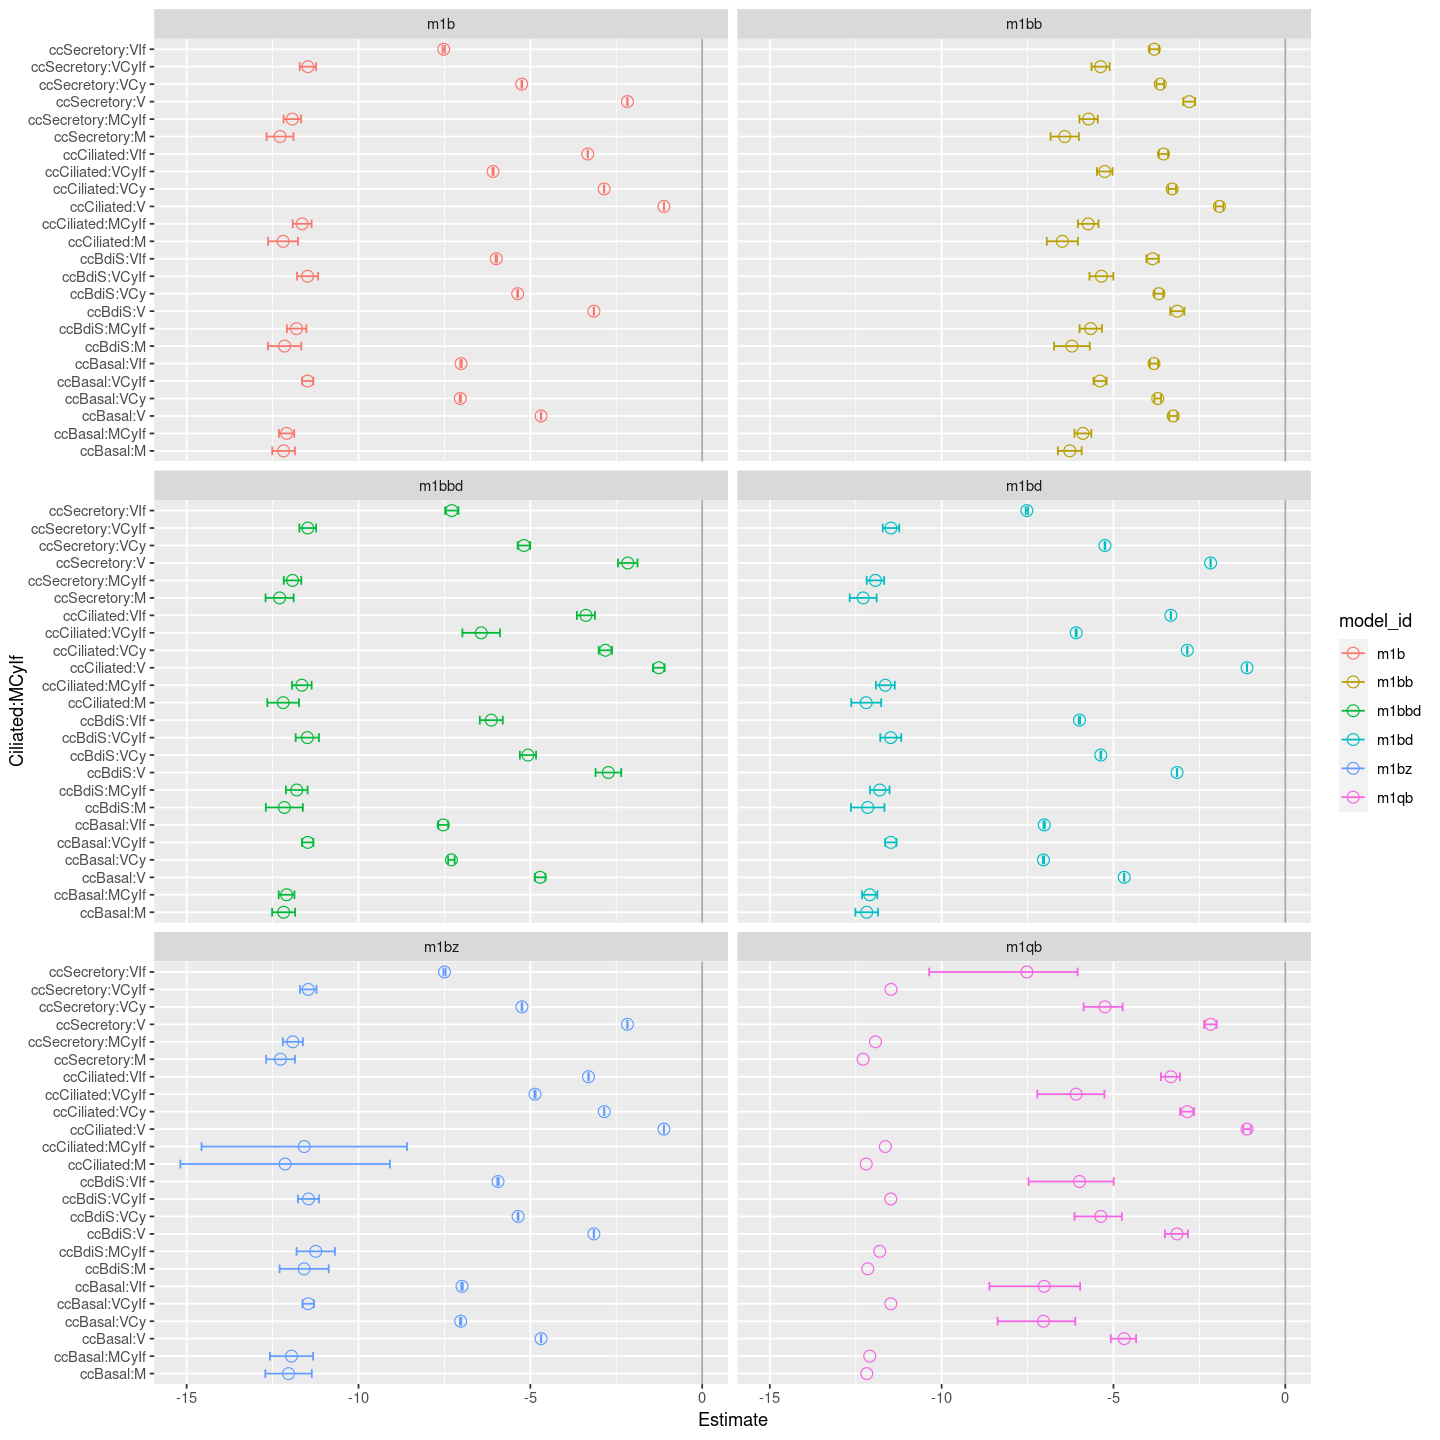

In [17]:
options(repr.plot.width=12, repr.plot.height=12)

(
    m1.cis.flat
    %>% ggplot()
    + geom_errorbarh(
        aes(y=coef_id, xmin=`0.5 %`, xmax=`99.5 %`, color=model_id, height=0.5),
            position = position_dodge2(reverse=TRUE, width = 0.5))
    + geom_point(
        aes(y=coef_id, x=Estimate, color=model_id), shape=1, size=3)
    + geom_vline(xintercept = 0, color='darkgrey')
    + scale_y_discrete(rev(cc_levels))
    + facet_wrap(vars(model_id), ncol=2)
)

# 3. Output for Beta-Binomial model

## 3.1 Confidence Intervals

In [18]:
(
    m1.cis.flat
    %>% filter(model_id == 'm1bbd')
    %>% reconstruct_cc('coef_id')
    %>% mutate_if(is.numeric, exp)
    %>% mutate_if(is.numeric, p_from_odds)
    %>% mutate(acc = 10^(2-1+floor(log10(`Estimate`))) %>% pmax(1e-4) %>% pmin(1))
    %>% mutate(Estimate = percent_v(Estimate, acc))
    %>% mutate(`0.5 %` = `0.5 %` %>% percent_v(acc))   
    %>% mutate(`99.5 %` = `99.5 %` %>% percent_v(acc))
    %>% arrange(cell_type, condition_short)
    %>% mutate(ci = sprintf('(%s-%s)', `0.5 %`, `99.5 %`))
    %>% mutate(ci_cell = paste(Estimate, ci, sep='N'))
    %>% select(condition_short, cell_type, ci_cell)
    %>% pivot_wider(names_from = cell_type, values_from=ci_cell)
)

condition_short,Basal,BdiS,Secretory,Ciliated
<ord>,<chr>,<chr>,<chr>,<chr>
M,0.0005%N(0.0004%-0.0007%),0.0005%N(0.0003%-0.0009%),0.0005%N(0.0003%-0.0007%),0.0005%N(0.0003%-0.0008%)
V,0.89%N(0.76%-1.04%),6.1%N(4.3%-8.7%),10%N(8%-13%),22%N(19%-25%)
VCy,0.068%N(0.062%-0.075%),0.62%N(0.49%-0.79%),0.56%N(0.46%-0.67%),5.7%N(4.7%-6.8%)
VIf,0.053%N(0.046%-0.062%),0.22%N(0.15%-0.30%),0.068%N(0.057%-0.083%),3.3%N(2.5%-4.2%)
VCyIf,0.0010%N(0.0009%-0.0012%),0.0010%N(0.0007%-0.0014%),0.0010%N(0.0008%-0.0013%),0.16%N(0.09%-0.28%)
MCyIf,0.0006%N(0.0004%-0.0007%),0.0008%N(0.0005%-0.0010%),0.0007%N(0.0005%-0.0009%),0.0009%N(0.0007%-0.0012%)


## 3.2 Contrasting set-up

In [19]:
basis_vector <- function(n, k) {
    v <- rep(0, n)
    v[[k]] <- 1
    v
}
basis_vector_v = Vectorize(basis_vector, SIMPLIFY = FALSE)

coefs <- (
    m1.summaries$m1bbd$coefficients$cond
    %>% as_tibble(rownames='coef_id')
    %>% mutate(coef_ix = row_number())
    %>% reconstruct_cc('coef_id')
    %>% select(cell_type, condition_short, coef_ix)
    %>% mutate(coef_v = basis_vector_v(n(), coef_ix))
)
coefs %>% head()

cell_type,condition_short,coef_ix,coef_v
<ord>,<ord>,<int>,<list>
Basal,M,1,"1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
BdiS,M,2,"0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
Secretory,M,3,"0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
Ciliated,M,4,"0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
Basal,V,5,"0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
BdiS,V,6,"0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"


In [20]:
# Difference of vectors in lists

ldiff <- function(lst1, lst2) {
    out <- list()
    for (i in seq(length(lst1))) {
        out[[i]] <- lst1[[i]] - lst2[[i]]
    }
    return(out)
}

l1 <- list(c(1,0,0), c(0,1,0))
l2 <- list(c(0,1,0), c(0,0,1))
ldiff(l1, l2)

[[1]]
[1]  1 -1  0

[[2]]
[1]  0  1 -1

In [21]:
test_contrast <- function(coef_v, only.p.value=TRUE) {
    test <- multcomp::glht(m1.models$m1bbd, linfct=t(matrix(coef_v)))
    s <- summary(test)
    if (only.p.value) {
        return(s$test$pvalue %>% as.numeric()) 
    } else {
        return(s$test)
    }
}

test_contrast_v <- Vectorize(test_contrast, SIMPLIFY=FALSE)

In [22]:
pstars <- function(p.values) (
    p.values
    %>% gtools::stars.pval()
    %>% str_replace_all('\\+', '')
)

## 3.3 Cell-type contrasts

In [23]:
cell_type_contrasts <- c('BdiS_vs_Basal', 'Secretory_vs_BdiS', 'Ciliated_vs_Secretory')

split_ctc <- function(tbl, varname) (
    tbl
    %>% mutate(ctcs = get(varname) %>% str_split('_vs_'))
    %>% mutate(ct1 = ctcs %>% map(~.x[[1]]) %>% restore_factor('cell_type'))
    %>% mutate(ct2 = ctcs %>% map(~.x[[2]]) %>% restore_factor('cell_type'))
    %>% select(-ctcs)   
)

ctc_long <- (
    crossing(
        tibble(condition_short=conditions_meta$condition_short),
        tibble(ctc=cell_type_contrasts))
    %>% split_ctc('ctc')
    %>% left_join(coefs %>% rename(ct1=cell_type, coef_v1=coef_v) %>% select(condition_short, ct1, coef_v1))
    %>% left_join(coefs %>% rename(ct2=cell_type, coef_v2=coef_v) %>% select(condition_short, ct2, coef_v2))
    %>% mutate(coef_v = ldiff(coef_v1, coef_v2))
    %>% select(-coef_v1, -coef_v2, -ct1, -ct2)
)
ctc_long %>% head()

Joining, by = c("condition_short", "ct1")

Joining, by = c("condition_short", "ct2")



condition_short,ctc,coef_v
<ord>,<chr>,<list>
M,BdiS_vs_Basal,"-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
M,Ciliated_vs_Secretory,"0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
M,Secretory_vs_BdiS,"0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
V,BdiS_vs_Basal,"0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
V,Ciliated_vs_Secretory,"0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
V,Secretory_vs_BdiS,"0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"


In [24]:
ctc_results <- (
    ctc_long
    %>% mutate(p.value = test_contrast_v(coef_v))
    %>% select(-coef_v)
    %>% pivot_wider(names_from=ctc, values_from=p.value)
    %>% mutate_if(is.numeric, pvalue_format(accuracy=1e-3))
)
ctc_results

condition_short,BdiS_vs_Basal,Ciliated_vs_Secretory,Secretory_vs_BdiS
<ord>,<list>,<list>,<list>
M,0.9336088,0.6668294,0.6014465
V,0,2.147615e-12,0.001940455
VCy,0,0,0.3091739
VIf,0,0,1.554312e-14
VCyIf,0.9346158,0,0.9370395
MCyIf,0.05088217,0.06777287,0.4359608


## 3.4 Condition Contrasts

In [25]:
condition_contrasts <-
    c('V_vs_M', 'VCy_vs_V', 'VIf_vs_V', 'VCyIf_vs_V', 'VCy_vs_VIf',
      'VCyIf_vs_VCy', 'VCyIf_vs_VIf', 'MCyIf_vs_M', 'VCyIf_vs_M')

split_cnc <- function(tbl, varname) (
    tbl
    %>% mutate(cncs = get(varname) %>% str_split('_vs_'))
    %>% mutate(cn1 = cncs %>% map(~.x[[1]]) %>% restore_factor('condition_short'))
    %>% mutate(cn2 = cncs %>% map(~.x[[2]]) %>% restore_factor('condition_short'))
    %>% select(-cncs)
)

cnc_long <- (
    crossing(
        tibble(cell_type=cell_type_levels %>% restore_factor('cell_type')),
        tibble(cnc=condition_contrasts))
    %>% split_cnc('cnc')
    %>% left_join(coefs %>% rename(cn1=condition_short, coef_v1=coef_v) %>% select(cell_type, cn1, coef_v1))
    %>% left_join(coefs %>% rename(cn2=condition_short, coef_v2=coef_v) %>% select(cell_type, cn2, coef_v2))
    %>% mutate(coef_v = ldiff(coef_v1, coef_v2))
    %>% select(-coef_v1, -coef_v2, -cn1, -cn2)
)
cnc_long %>% head()

Joining, by = c("cell_type", "cn1")

Joining, by = c("cell_type", "cn2")



cell_type,cnc,coef_v
<ord>,<chr>,<list>
Basal,MCyIf_vs_M,"-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0"
Basal,VCyIf_vs_M,"-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0"
Basal,VCyIf_vs_V,"0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0"
Basal,VCyIf_vs_VCy,"0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0"
Basal,VCyIf_vs_VIf,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0"
Basal,VCy_vs_V,"0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"


In [26]:
cnc_results <- (
    cnc_long
    %>% mutate(results = test_contrast_v(coef_v, only.p.value = FALSE))
    %>% select(-coef_v)
    %>% mutate(value = results %>% map_dbl(~.x$coef))
    %>% mutate(p.value = results %>% map_dbl(~.x$pvalue))
    %>% mutate(value = results %>% map_dbl(~.x$coef))
    %>% select(-results)
    #%>% pivot_wider(names_from=cell_type, values_from=values)
    #%>% mutate_if(is.numeric, pvalue_format(accuracy=1e-3))
)
cnc_results

cell_type,cnc,value,p.value
<ord>,<chr>,<dbl>,<dbl>
Basal,MCyIf_vs_M,0.0866461,5.824710e-01
Basal,VCyIf_vs_M,0.7017772,1.303932e-06
Basal,VCyIf_vs_V,-6.7629307,0.000000e+00
Basal,VCyIf_vs_VCy,-4.1808329,0.000000e+00
Basal,VCyIf_vs_VIf,-3.9420254,0.000000e+00
Basal,VCy_vs_V,-2.5820977,0.000000e+00
Basal,VCy_vs_VIf,0.2388075,3.897911e-04
Basal,VIf_vs_V,-2.8209053,0.000000e+00
Basal,V_vs_M,7.4647079,0.000000e+00


In [27]:
(
    cnc_results
    %>% select(-value)
    %>% pivot_wider(names_from=cell_type, values_from=p.value)
    %>% mutate_if(is.numeric, pvalue_format(accuracy=1e-3))
)

cnc,Basal,BdiS,Secretory,Ciliated
<chr>,<chr>,<chr>,<chr>,<chr>
MCyIf_vs_M,0.582,0.136,0.044,0.010
VCyIf_vs_M,<0.001,0.007,<0.001,<0.001
VCyIf_vs_V,<0.001,<0.001,<0.001,<0.001
VCyIf_vs_VCy,<0.001,<0.001,<0.001,<0.001
VCyIf_vs_VIf,<0.001,<0.001,<0.001,<0.001
VCy_vs_V,<0.001,<0.001,<0.001,<0.001
VCy_vs_VIf,<0.001,<0.001,<0.001,<0.001
VIf_vs_V,<0.001,<0.001,<0.001,<0.001
V_vs_M,<0.001,<0.001,<0.001,<0.001


## 3.5 Contrast decreases between cell-types

Comparing deltas in viral load (e.g. Cyclodextrin vs Untreated) across cell types

In [28]:
cell_type_contrasts <- c('BdiS_vs_Basal', 'Secretory_vs_BdiS', 'Ciliated_vs_Basal')
condition_contrasts <- c('VCy_vs_V', 'VIf_vs_V', 'VCyIf_vs_V')

coefs_s <- coefs %>% select(-coef_ix)
cc2_long <- (
    crossing(
        tibble(ctc=cell_type_contrasts),
        tibble(cnc=condition_contrasts))
    %>% split_ctc('ctc')
    %>% split_cnc('cnc')
    #
    %>% left_join(coefs_s %>% rename(ct1=cell_type, cn1=condition_short, v_ct1_cn1=coef_v))
    %>% left_join(coefs_s %>% rename(ct1=cell_type, cn2=condition_short, v_ct1_cn2=coef_v))
    %>% mutate(v_ct1 = ldiff(v_ct1_cn1, v_ct1_cn2))
    %>% select(-v_ct1_cn1, -v_ct1_cn2)
    #
    %>% left_join(coefs_s %>% rename(ct2=cell_type, cn1=condition_short, v_ct2_cn1=coef_v))
    %>% left_join(coefs_s %>% rename(ct2=cell_type, cn2=condition_short, v_ct2_cn2=coef_v))
    %>% mutate(v_ct2 = ldiff(v_ct2_cn1, v_ct2_cn2))
    %>% select(-v_ct2_cn1, -v_ct2_cn2)
    #
    %>% mutate(coef_v = ldiff(v_ct1, v_ct2))
    %>% select(-v_ct1, -v_ct2)
)
cc2_long %>% head()

Joining, by = c("ct1", "cn1")

Joining, by = c("ct1", "cn2")

Joining, by = c("ct2", "cn1")

Joining, by = c("ct2", "cn2")



ctc,cnc,ct1,ct2,cn1,cn2,coef_v
<chr>,<chr>,<ord>,<ord>,<ord>,<ord>,<list>
BdiS_vs_Basal,VCyIf_vs_V,BdiS,Basal,VCyIf,V,"0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0"
BdiS_vs_Basal,VCy_vs_V,BdiS,Basal,VCy,V,"0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
BdiS_vs_Basal,VIf_vs_V,BdiS,Basal,VIf,V,"0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
Ciliated_vs_Basal,VCyIf_vs_V,Ciliated,Basal,VCyIf,V,"0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0"
Ciliated_vs_Basal,VCy_vs_V,Ciliated,Basal,VCy,V,"0, 0, 0, 0, 1, 0, 0, -1, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0"
Ciliated_vs_Basal,VIf_vs_V,Ciliated,Basal,VIf,V,"0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0"


In [29]:
cc2_results <- (
    cc2_long
    %>% mutate(results = test_contrast_v(coef_v, only.p.value = FALSE))
    %>% select(-coef_v, -ct1, -ct2, -cn1, -cn2)
    %>% mutate(p.value = results %>% map_dbl(~.x$pvalue))
    #%>% mutate(values = results %>% map_dbl(~.x$coef) %>% number_format(accuracy=1e-2)())
    #%>% mutate(values = paste(values, pstars, sep=''))
    %>% select(-results)
    %>% pivot_wider(names_from=cnc, values_from=p.value)
    %>% mutate_if(is.numeric, pvalue_format(accuracy=1e-3))
)
cc2_results

ctc,VCyIf_vs_V,VCy_vs_V,VIf_vs_V
<chr>,<chr>,<chr>,<chr>
BdiS_vs_Basal,<0.001,0.190,0.005
Ciliated_vs_Basal,<0.001,<0.001,<0.001
Secretory_vs_BdiS,0.024,0.002,<0.001


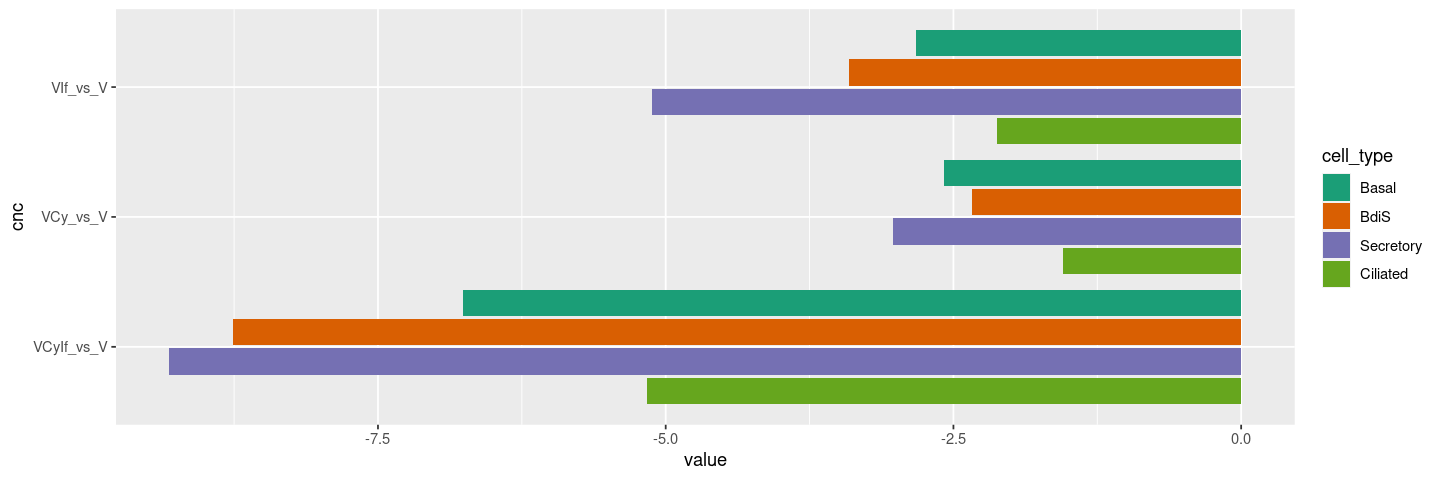

In [30]:
options(repr.plot.width=12, repr.plot.height=4)

(
    cnc_results
    %>% filter(cnc %in% condition_contrasts)
    %>% ggplot(aes(y=cnc, fill=cell_type, x=value))
    + geom_col(position=position_dodge2(reverse=TRUE))
    + scale_fill_manual(values=cell_type_colors)
)

In [31]:
(
    cnc_results
    %>% filter(cnc %in% condition_contrasts)
    %>% select(-p.value)
    %>% pivot_wider(names_from=cell_type, values_from=value)
    %>% mutate_if(is.numeric, number_format(accuracy=1e-2))
)

cnc,Basal,BdiS,Secretory,Ciliated
<chr>,<chr>,<chr>,<chr>,<chr>
VCyIf_vs_V,-6.76,-8.76,-9.31,-5.17
VCy_vs_V,-2.58,-2.34,-3.02,-1.55
VIf_vs_V,-2.82,-3.41,-5.12,-2.12


# 5. Session Info

In [32]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux bookworm/sid

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
[1] C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.1.1       SeuratObject_4.0.4 Seurat_4.0.5       forcats_0.5.1     
 [5] stringr_1.4.0      dplyr_1.0.7        readr_2.1.0        tidyr_1.1.4       
 [9] tibble_3.1.6       ggplot2_3.3.5      tidyverse_1.3.0    purrr_0.3.4       

loaded via a namespace (and not attached):
  [1] readxl_1.3.1          uuid_1.0-3            backports_1.4.0      
  [4] plyr_1.8.6            igraph_1.2.9          repr_1.1.3           
  [7] lazyeval_0.2.2        TMB_1.7.22            splines_4.1.2        
 [10] listenv_0.8.0         scattermore_0.7       TH.data_1.1-0        
 [13] digest_0.6.29         